# Import libraries

In [ ]:
!pip install bitermplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 615 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitermplus: filename=bitermplus-0.6.12-cp37-cp37m-linux_x86_64.whl size=939345 sha256=cfc74ded85091358c7032b71efcb01681a557456167d849e0760474aa2a198db
  Stored in directory: /root/.cache/pip/wheels/76/8a/2f/de2ee90ae07b7cc412dd835313ba4c6a45cdba7971310577c1
Successfully built bitermplus


In [ ]:
!pip install tmplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tmplot: filename=tmplot-0.0.8-py3-none-any.whl size=17293 sha256=9f022cd67ae1c98b9caf6c6dbf620a2ffaab2f343dc33d8b73c308c0e26b39f8
  Stored in directory: /root/.cache/pip/wheels/75/9c/0a/e186575ff76438e0dd78484634a86fbdde2bdf56bdea8ae007
Successfully built tmplot


In [ ]:
import bitermplus as btm
import numpy as np
import pandas as pd
import tmplot as tmp

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [ ]:
!pip install -U gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 27.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
abstracts = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/prep_readmes0.csv",
                        index_col=0)
abstracts.Tokens = abstracts.Tokens.apply(eval)
texts = [' '.join(i) for i in abstracts.Tokens]

# Create biterms set

In [ ]:
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
biterms = btm.get_biterms(docs_vec)
diccionario = Dictionary(abstracts.Tokens)

# Hyperparameter tuning

## First round

In [ ]:
# Topics range
min_topics = 5
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
alpha = [0.01, 0.1, 1, 10]
beta_aux = [1, 10, 20]
results = []
for k in topics_range:
  for b in beta_aux:
    for a in alpha:
      model = btm.BTM(X, vocabulary, seed=12321, T=k, M=10, alpha=a, beta=b/k)
      model.fit(biterms, iterations=50)
      words_topics = btm.get_top_topic_words(model)
      words_per_topic = words_topics.transpose().values.tolist()
      umass_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='u_mass')
      npmi_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='c_npmi')
      results.append([k, a, b/k, b, umass_btm.get_coherence(), npmi_btm.get_coherence()])
evaluation = pd.DataFrame(results, columns=['Number_topics', 'Alpha', 'Beta', 'Num', 'UMASS','NPMI'])

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


In [ ]:
with open("/content/drive/MyDrive/TFM_FINAL/hptuning_btm_readme0.csv", 'w', encoding = 'utf-8-sig') as f:
  evaluation.to_csv(f)

In [ ]:
evaluation.sort_values('UMASS', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
13,6,0.10,0.166667,1,-0.992606,0.028474
15,6,10.00,0.166667,1,-0.993868,0.028474
12,6,0.01,0.166667,1,-0.994188,0.028474
14,6,1.00,0.166667,1,-0.995253,0.028474
0,5,0.01,0.200000,1,-1.094882,0.022911
...,...,...,...,...,...,...
34,7,1.00,2.857143,20,-1.872694,0.016145
59,9,10.00,2.222222,20,-2.491253,0.011142
58,9,1.00,2.222222,20,-2.494060,0.011142
57,9,0.10,2.222222,20,-2.495217,0.011142


In [ ]:
evaluation.sort_values('NPMI', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
118,14,1.00,1.428571,20,-1.223804,0.073485
117,14,0.10,1.428571,20,-1.220238,0.073128
116,14,0.01,1.428571,20,-1.220582,0.073128
119,14,10.00,1.428571,20,-1.207639,0.072998
114,14,1.00,0.714286,10,-1.210073,0.068740
...,...,...,...,...,...,...
35,7,10.00,2.857143,20,-1.872146,0.016145
56,9,0.01,2.222222,20,-2.497539,0.011142
57,9,0.10,2.222222,20,-2.495217,0.011142
58,9,1.00,2.222222,20,-2.494060,0.011142


## Second round

In [ ]:
# Topics range
min_topics = 6
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
alpha = [0.15,  0.5]
results = []
for k in topics_range:
  for a in alpha:
    model = btm.BTM(X, vocabulary, seed=12321, T=k, M=10, alpha=a, beta=1/k) 
    model.fit(biterms, iterations=50)
    words_topics = btm.get_top_topic_words(model)
    words_per_topic = words_topics.transpose().values.tolist()
    umass_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='u_mass')
    npmi_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='c_npmi')
    results.append([k, a, 1/k, 1, umass_btm.get_coherence(), npmi_btm.get_coherence()])
evaluation_2 = pd.DataFrame(results, columns=['Number_topics', 'Alpha', 'Beta', 'Num', 'UMASS','NPMI'])

100%|██████████| 50/50 [04:24<00:00,  5.30s/it]


In [ ]:
with open("/content/drive/MyDrive/TFM_FINAL/hptuning_btm_readme0_2.csv", 'w', encoding = 'utf-8-sig') as f:
  evaluation_2.to_csv(f)

## Choosing best model

In [ ]:
evaluation = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/hptuning_btm_readme0.csv", 
                          index_col=0)
evaluation_2 = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/hptuning_btm_readme0_2.csv", 
                            index_col=0)

In [ ]:
final_eval = [evaluation, evaluation_2]
final_eval = pd.concat(final_eval)

In [ ]:
final_eval = final_eval.drop_duplicates()
final_eval = final_eval.reset_index(drop=True)

In [ ]:
final_eval.sort_values('UMASS', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
121,6,0.50,0.166667,1,-0.991690,0.028476
13,6,0.10,0.166667,1,-0.992606,0.028474
120,6,0.15,0.166667,1,-0.993495,0.028476
15,6,10.00,0.166667,1,-0.993868,0.028474
12,6,0.01,0.166667,1,-0.994188,0.028474
...,...,...,...,...,...,...
34,7,1.00,2.857143,20,-1.872694,0.016145
59,9,10.00,2.222222,20,-2.491253,0.011142
58,9,1.00,2.222222,20,-2.494060,0.011142
57,9,0.10,2.222222,20,-2.495217,0.011142


In [ ]:
final_eval.sort_values('NPMI', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
118,14,1.00,1.428571,20,-1.223804,0.073485
117,14,0.10,1.428571,20,-1.220238,0.073128
116,14,0.01,1.428571,20,-1.220582,0.073128
119,14,10.00,1.428571,20,-1.207639,0.072998
114,14,1.00,0.714286,10,-1.210073,0.068740
...,...,...,...,...,...,...
32,7,0.01,2.857143,20,-1.872023,0.016145
59,9,10.00,2.222222,20,-2.491253,0.011142
58,9,1.00,2.222222,20,-2.494060,0.011142
57,9,0.10,2.222222,20,-2.495217,0.011142


We see that based on UMASS the best values are alpha=10 and beta=20/K, however when looking at the highest NPMI values the hyperparameters are more heterogeneous. We'll study first alpha=1 and beta=10/K??????CAMBIAR ESTO ES DE LDA

In [ ]:
v1 = final_eval.loc[final_eval['Num']==1]
v1 = v1.loc[v1['Alpha']==0.01]
v2 = final_eval.loc[final_eval['Num']==1]
v2 = v2.loc[v2['Alpha']==0.1]
v3 = final_eval.loc[final_eval['Num']==10]
v3 = v3.loc[v3['Alpha']==10]
v4 = final_eval.loc[final_eval['Num']==10]
v4 = v4.loc[v4['Alpha']==0.01]

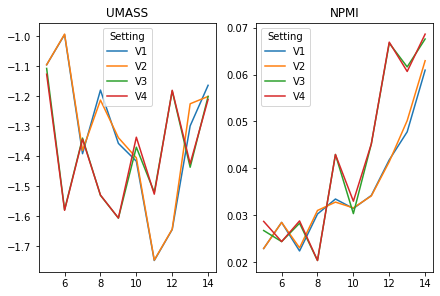

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout=True)

x = np.arange(5, 15, step=1)
ax1.plot(x,v1.UMASS,label='V1')
ax1.plot(x,v2.UMASS,label='V2')
ax1.plot(x,v3.UMASS,label='V3')
ax1.plot(x,v4.UMASS,label='V4')
ax1.legend(title='Setting')
ax1.set_title('UMASS')

ax2.plot(x,v1.NPMI,label='V1')
ax2.plot(x,v2.NPMI,label='V2')
ax2.plot(x,v3.NPMI,label='V3')
ax2.plot(x,v4.NPMI,label='V4')
ax2.legend(title='Setting')
ax2.set_title('NPMI')
#ax2.xticks(x)
plt.show()

We choose the model with k=12 topics, and V4 settings (i.e alpha=0.01 and beta = 10/k (note that this decission is totally subjective and another researcher may decide that this is not the most suitable model)

In [ ]:
model = btm.BTM(X, vocabulary, seed=12321, T=12, M=10, alpha=0.01, beta=10/12) 
model.fit(biterms, iterations=50)
words_topics = btm.get_top_topic_words(model)
words_per_topic = words_topics.transpose().values.tolist()

100%|██████████| 50/50 [03:45<00:00,  4.51s/it]


In [ ]:
umass_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='c_npmi')
umass = umass_btm.get_coherence()
npmi = npmi_btm.get_coherence()

In [ ]:
print('UMASS of final model:', umass)
print('NPMI of final model:', npmi)

UMASS of final model: -1.1799503739124486
NPMI of final model: 0.06690795328862044


# Analysis

In [ ]:
top_words = btm.get_top_topic_words(model)
top_words

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11
0,learn,imag,layer,train,yolo,que,nbsp,model,learn,model,instal,http
1,use,generat,use,model,detect,para,bert,train,network,use,use,arxiv
2,agent,dataset,size,use,object,modelo,model,resnet,model,data,python,licens
3,train,use,train,file,train,los,train,test,neural,dataset,pytorch,author
4,time,train,model,dataset,yolov,est,languag,result,use,train,run,pleas
5,result,network,batch,run,weight,por,word,imagenet,deep,code,code,paper
6,environ,png,loss,imag,map,las,base,dataset,implement,text,tensorflow,cite
7,algorithm,gan,input,data,coco,del,token,download,paper,project,implement,com
8,one,segment,output,set,use,con,pre,link,convolut,task,version,titl
9,perform,model,number,test,fps,una,task,accuraci,attent,languag,requir,code


In [ ]:
tmp.report(model= model, docs=texts)

/usr/local/lib/python3.7/dist-packages/tmplot/_helpers.py:39: UserWarning: Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.
  f'Please install "{package_name}" package to analyze its models.\n'
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'squa

In [ ]:
abstracts['Topic'] = btm.get_docs_top_topic(texts, model.matrix_docs_topics_).label

In [ ]:
prob_mat = model.transform(docs_vec)
Topic_1 = [] 
Confidence_1 = []
Topic_2 = []
Confidence_2 = []
for i in range(len(prob_mat)):
  ord = sorted(prob_mat[i],reverse=True)
  prob_1 = ord[0]
  prob_2 = ord[1]
  top_1 = np.where(prob_mat[i] == ord[0])
  Topic_1.append(int(top_1[0]))
  top_2 = np.where(prob_mat[i] == ord[1])
  Topic_2.append(int(top_2[0]))
  choices = ['High', 'Medium', 'Low']
  conditions_1 = [prob_1>=0.66, (prob_1<0.66) & (prob_1>=0.33),
                  prob_1<0.33]
  conf_1 = np.select(conditions_1,choices)
  Confidence_1.append(conf_1)
  conditions_2 = [prob_2>=0.66, (prob_2<0.66) & (prob_2>=0.33),
                  prob_2<0.33]
  conf_2 = np.select(conditions_2,choices)
  Confidence_2.append(conf_2)

100%|██████████| 8194/8194 [00:03<00:00, 2670.64it/s]


In [ ]:
abstracts['Topic_1'] = Topic_1
abstracts['Confidence_1'] = Confidence_1
abstracts['Topic_2'] = Topic_2
abstracts['Confidence_2'] = Confidence_2
abstracts.head()

,readmes,label,Tokens,Topic_1,Confidence_1,Topic_2,Confidence_2
0,b'# PSIS\n\nData Augmentation for Object Detec...,Computer Vision,"[psis, data, augment, object, detect, via, pro...",7,Low,3,Low
1,b'# SNIPER / AutoFocus: Efficient Multi-Scale ...,Computer Vision,"[sniper, autofocus, effici, multi, scale, trai...",3,Medium,7,Low
2,b'# SNIPER: Efficient Multi-Scale Training\n\n...,Computer Vision,"[sniper, effici, multi, scale, train, sniper, ...",3,Medium,7,Low
3,b'\xe7\xae\x80\xe4\xbd\x93\xe4\xb8\xad\xe6\x96...,Computer Vision,"[english, readm, img, src, href, src, img, src...",7,Medium,4,Low
4,b'# Model Based RL papers\n\n<h3>Papers List</...,Sequential,"[model, base, paper, paper, list, word, discov...",8,Medium,0,Low


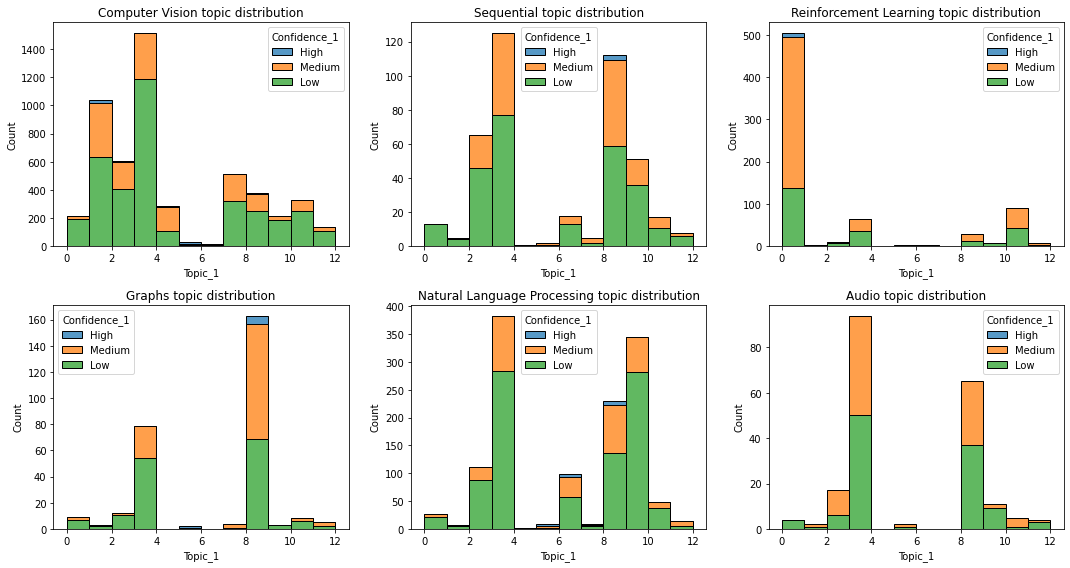

In [ ]:
for i in range(len(abstracts)):
  abstracts.loc[i,'Confidence_1'] = str(abstracts.loc[i,'Confidence_1'])
  abstracts.loc[i,'Confidence_2'] = str(abstracts.loc[i,'Confidence_2'])
plt.figure(figsize=(15,8), tight_layout=True)
labels = abstracts['label'].unique()
i = 1
for lab in labels:
  plt.subplot(2,3,i)
  i = i+1
  df3 = abstracts[abstracts['label']==lab]
  sns.histplot(data=df3,x='Topic_1', hue="Confidence_1", 
               multiple="stack", binwidth=1,binrange=(0,12), hue_order=['High', 'Medium', 'Low'])
  plt.title(f'{lab} topic distribution')
plt.show()